### Downloading the Dataset

In [ ]:
!pip install kaggle


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### Performing EDA

In [ ]:
import os

base_dir = "chest_xray"
for folder in ["train", "test", "val"]:
    print(folder, os.listdir(os.path.join(base_dir, folder)))


train ['NORMAL', 'PNEUMONIA']
test ['NORMAL', 'PNEUMONIA']
val ['NORMAL', 'PNEUMONIA']


In [ ]:
def count_images(path):
    return len(os.listdir(path))

train_normal = count_images("chest_xray/train/NORMAL")
train_pneumonia = count_images("chest_xray/train/PNEUMONIA")

print("NORMAL:", train_normal)
print("PNEUMONIA:", train_pneumonia)


NORMAL: 1341
PNEUMONIA: 3875


##### Dataset is imbalanced with significantly more pneumonia cases.

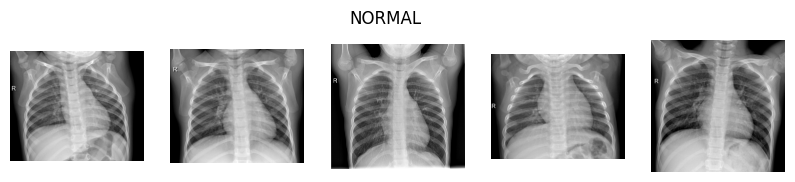

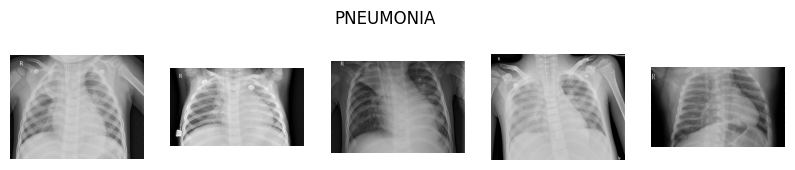

In [ ]:
# Visualizing Samples

import matplotlib.pyplot as plt
from PIL import Image
import random

def show_images(folder, title):
    images = random.sample(os.listdir(folder), 5)
    plt.figure(figsize=(10,2))
    for i, img in enumerate(images):
        plt.subplot(1,5,i+1)
        plt.imshow(Image.open(os.path.join(folder, img)), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images("chest_xray/train/NORMAL", "NORMAL")
show_images("chest_xray/train/PNEUMONIA", "PNEUMONIA")


### Creating Image Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)


###Creating Data Loaders

In [ ]:
train_data = train_gen.flow_from_directory(
    "chest_xray/train",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_data = test_gen.flow_from_directory(
    "chest_xray/val",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    "chest_xray/test",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Giving Class Weights

In [ ]:
class_weight = {
    0: train_pneumonia / train_normal,  # NORMAL will have more penalty
    1: 1.0                               # PNEUMONIA
}


### Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


In [ ]:
# Transfer Learning

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    class_weight=class_weight,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 693ms/step - accuracy: 0.7602 - loss: 0.7609 - precision: 0.8904 - recall: 0.7781 - val_accuracy: 0.9375 - val_loss: 0.2875 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 625ms/step - accuracy: 0.8817 - loss: 0.3719 - precision: 0.9630 - recall: 0.8755 - val_accuracy: 0.8750 - val_loss: 0.2500 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.9188 - loss: 0.2854 - precision: 0.9787 - recall: 0.9096 - val_accuracy: 0.8750 - val_loss: 0.2596 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.9185 - loss: 0.2634 - precision: 0.9811 - recall: 0.9062 - val_accuracy: 0.8750 - val_loss: 0.2415 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631

### Fine Tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.fit(train_data, epochs=10, validation_data=val_data)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 641ms/step - accuracy: 0.8842 - loss: 0.2895 - val_accuracy: 0.8750 - val_loss: 0.2122
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.9302 - loss: 0.1838 - val_accuracy: 0.9375 - val_loss: 0.2421
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.9329 - loss: 0.1577 - val_accuracy: 0.7500 - val_loss: 0.4272
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9392 - loss: 0.1506 - val_accuracy: 0.7500 - val_loss: 0.5561
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9527 - loss: 0.1274 - val_accuracy: 0.7500 - val_loss: 0.4869
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 613ms/step - accuracy: 0.9553 - loss: 0.1214 - val_accuracy: 0.7500 - val_loss: 0.5182
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9617 - loss: 0.1016 - val_accuracy: 0.7500 - val_loss: 0.5356
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.9586 - 

### Saving Model

In [ ]:
model.save("mobilenetv2_pneumonia.h5")


### Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(test_data)
y_pred = (preds > 0.5).astype(int)

print(classification_report(test_data.classes, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step
              precision    recall  f1-score   support

           0       0.96      0.62      0.75       234
           1       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



<Axes: >

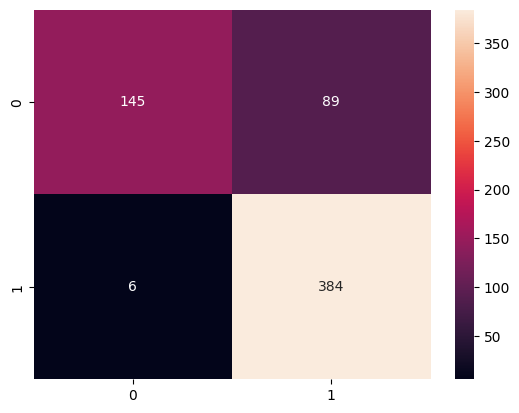

In [ ]:
# confusion matrix

import seaborn as sns

cm = confusion_matrix(test_data.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


### GRAD CAM

##### importing libraries and model

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
model = tf.keras.models.load_model("mobilenetv2_pneumonia.h5")


In [ ]:
# finding last convolution layer

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,267 (8.62 MB)

 Trainable params: 1,207,361 (4.61 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
last_conv_layer_name = "Conv_1"


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + tf.keras.backend.epsilon()

    return heatmap.numpy()


### Load and Prepare Image

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


In [ ]:
raw_heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name
)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
print(
    "RAW heatmap min/max:",
    raw_heatmap.min(),
    raw_heatmap.max(),
    "mean:",
    raw_heatmap.mean()
)


RAW heatmap min/max: 0.0 0.99517983 mean: 0.5749633


In [ ]:
# Read image (OpenCV uses BGR)
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))

# Resize raw heatmap (still float 0–1)
heatmap_resized = cv2.resize(
    raw_heatmap,
    (img.shape[1], img.shape[0])
)

# Convert ONLY for visualization
heatmap_uint8 = np.uint8(255 * heatmap_resized)

# Apply colormap
heatmap_color = cv2.applyColorMap(
    heatmap_uint8,
    cv2.COLORMAP_JET
)

# Overlay
superimposed_img = cv2.addWeighted(
    img, 0.6, heatmap_color, 0.4, 0
)


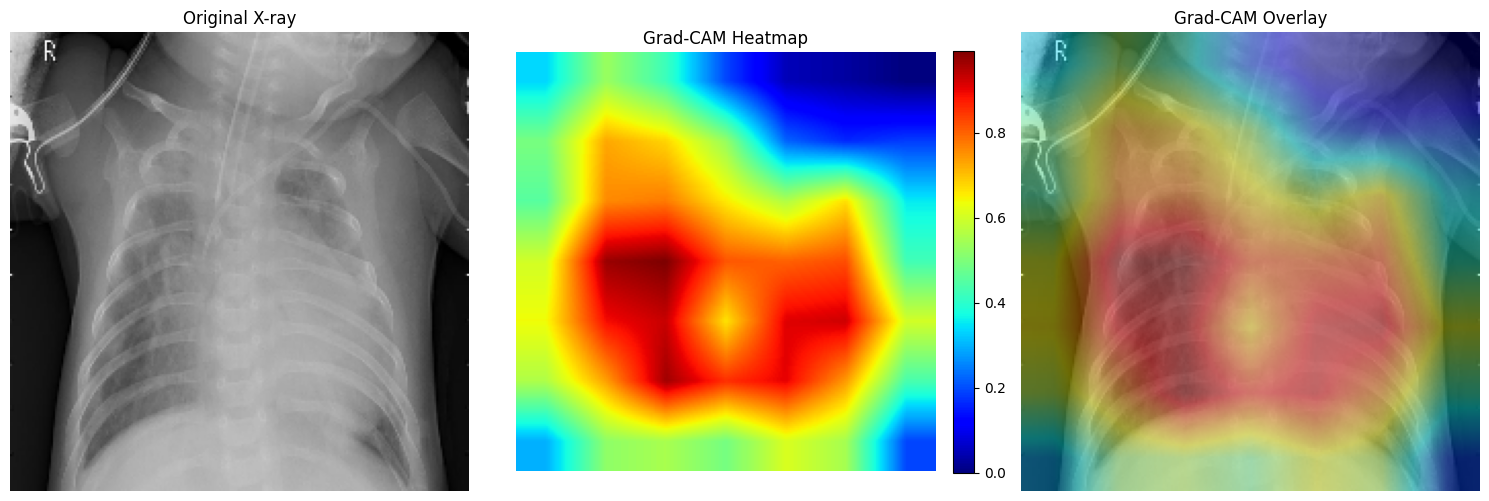

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 1. Original X-ray (RGB)
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224,224))
orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# 2. Raw Grad-CAM heatmap (0–1)
plt_heatmap = cv2.resize(raw_heatmap, (224,224))

# 3. Grad-CAM overlay (already computed earlier)
overlay_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# ---- Plot all three side-by-side ----
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig_img_rgb)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(plt_heatmap, cmap="jet")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay_rgb)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
